In [1]:
import mlx.core as mx
import mlx.nn as nn
from mlx.data import datasets
import mlx.optimizers as optim
from datasets_utils import cifar100
from mlx.utils import tree_flatten


In [2]:
cifar100_train = datasets.load_cifar100(train=True)
cifar100_test = datasets.load_cifar100(train=False)

len(cifar100_train), len(cifar100_test)

(50000, 10000)

In [3]:
def get_streamed_data(data, batch_size=0, shuffled=True):
    def transform(x):
        return x.astype("float32") / 255.0

    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.key_transform("image", transform)
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

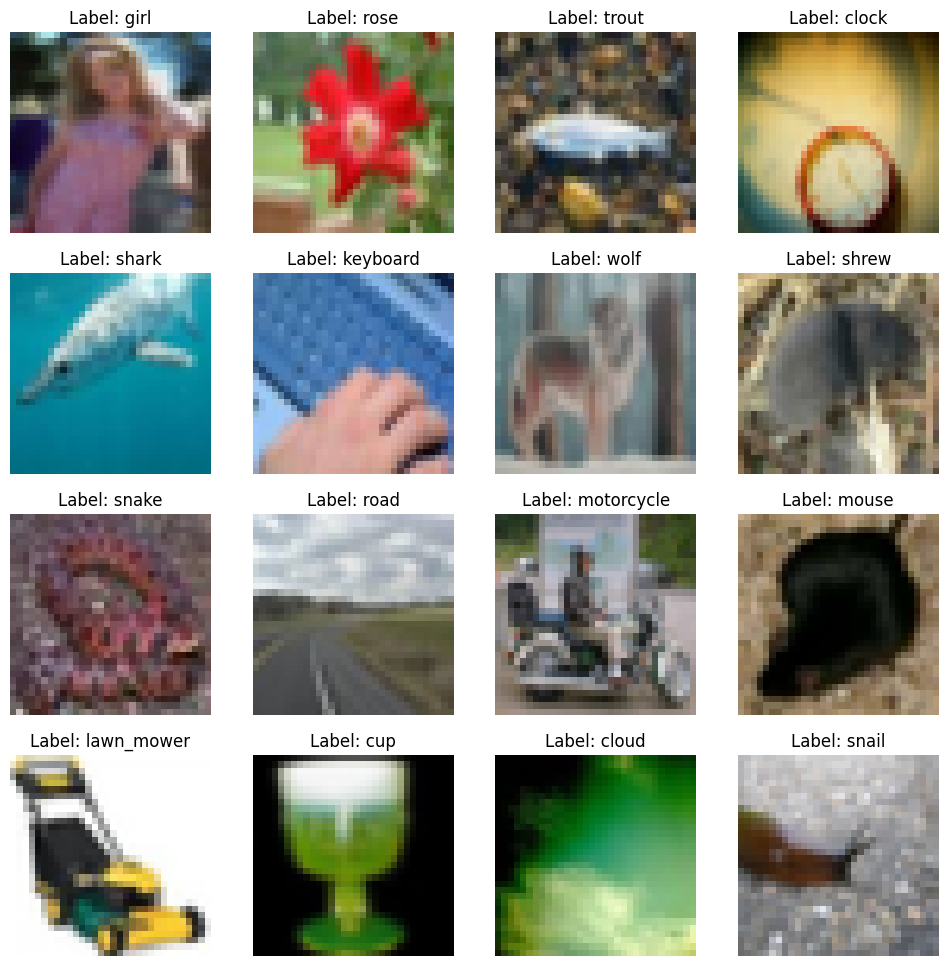

In [4]:
import matplotlib.pyplot as plt
mx.random.seed(42)

n_cols = 4
n_rows = 4
fig = plt.figure(figsize=(12, 12))
for i, batch in zip(range(n_cols * n_rows), get_streamed_data(cifar100_train, batch_size=1)):    
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    img = mx.array(batch["image"])
    label = batch["label"].squeeze()
    label = cifar100.labels[label]
    img = img.astype(mx.float32)
    ax.set_title(f"Label: {label}")
    ax.set_axis_off()
    ax.imshow(img.squeeze())
plt.show()

In [5]:
class ShortcutA(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims
    def __call__(self, x):
        return mx.pad(
            x[:, ::2, ::2, :],
            pad_width=[(0, 0), (0, 0), (0, 0), (self.dims // 4, self.dims // 4)],
        )

class ResidualBlock(nn.Module):
    def __init__(self, in_dims, dims, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_dims, dims, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm(dims)
        self.conv2 = nn.Conv2d(dims, dims, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm(dims)

        self.shortcut = ShortcutA(dims) if stride != 1 else None
    
    def __call__(self, x):
        out = nn.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is None:
            out += x
        else:
            out += self.shortcut(x)
        out = nn.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm(16)

        self.layer1 = self._make_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
    
    def _make_layer(self, in_dims, dims, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(in_dims, dims, stride))
            in_dims = dims
        return nn.Sequential(*layers)

    def num_params(self):
        nparams = sum(x.size for k, x in tree_flatten(self.parameters()))
        return nparams

    def __call__(self, x):
        x = nn.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = mx.mean(x, axis=[1, 2]).reshape(x.shape[0], -1)
        x = self.linear(x)
        return x

In [6]:
model = ResNet([5, 5, 5], num_classes=len(cifar100.labels))
mx.eval(model)
model

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
  (bn1): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (layers.0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
      (bn1): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
      (bn2): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layers.1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
      (bn1): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
      (bn2): BatchNorm(16, eps

In [7]:
import trainer

epochs = 50
# optimizer = optim.Adam(learning_rate=0.005)
optimizer = optim.Adam(learning_rate=0.0005)

train_data = get_streamed_data(batch_size=512, data=cifar100_train, shuffled=True)
test_data = get_streamed_data(batch_size=512, data=cifar100_test, shuffled=False)

train_accuracies = []
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc, throughput = trainer.train_epoch(model, train_data, optimizer, epoch, verbose=False)
    print(" | ".join(
                (
                    f"Epoch: {epoch+1}",
                    f"avg. Train loss {train_loss.item():.3f}",
                    f"avg. Train acc {train_acc.item():.3f}",
                    f"Throughput: {throughput.item():.2f} images/sec",
                )))
    test_acc = trainer.test_epoch(model, test_data, epoch)
    print(f"Epoch: {epoch+1} | Test acc {test_acc.item():.3f}")

    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    test_accuracies.append(test_acc)

    train_data.reset()
    test_data.reset()

Epoch: 1 | avg. Train loss 4.591 | avg. Train acc 0.028 | Throughput: 2438.24 images/sec
Epoch: 1 | Test acc 0.038
Epoch: 2 | avg. Train loss 4.574 | avg. Train acc 0.046 | Throughput: 2049.59 images/sec
Epoch: 2 | Test acc 0.055
Epoch: 3 | avg. Train loss 4.564 | avg. Train acc 0.058 | Throughput: 2129.19 images/sec
Epoch: 3 | Test acc 0.063
Epoch: 4 | avg. Train loss 4.558 | avg. Train acc 0.064 | Throughput: 2258.06 images/sec
Epoch: 4 | Test acc 0.068
Epoch: 5 | avg. Train loss 4.554 | avg. Train acc 0.067 | Throughput: 2300.62 images/sec
Epoch: 5 | Test acc 0.068
Epoch: 6 | avg. Train loss 4.550 | avg. Train acc 0.072 | Throughput: 2549.39 images/sec
Epoch: 6 | Test acc 0.074
Epoch: 7 | avg. Train loss 4.546 | avg. Train acc 0.076 | Throughput: 2618.03 images/sec
Epoch: 7 | Test acc 0.075
Epoch: 8 | avg. Train loss 4.544 | avg. Train acc 0.078 | Throughput: 2696.24 images/sec
Epoch: 8 | Test acc 0.078
Epoch: 9 | avg. Train loss 4.541 | avg. Train acc 0.081 | Throughput: 2665.85 im

In [8]:
# get precision, recall, and f1-score
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

y_true = []
y_pred = []
model.eval()
for batch in test_data:
    X, y = batch["image"], batch["label"]
    X, y = mx.array(X), mx.array(y)
    logits = model(X)
    prediction = mx.argmax(mx.softmax(logits), axis=1)
    y_true = y_true + y.tolist()
    y_pred = y_pred + prediction.tolist()
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

test_data.reset()

Precision: 0.043967205405420054
Recall: 0.1291
F1 Score: 0.06249543552231596


/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
